# Dataset per GENRES

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats



import plotly.offline as py
import plotly.graph_objs as go

import seaborn as sns

import missingno as msno

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils
from utils import load
import plotly.express as px
import plotly.graph_objects as go

# Preso dal file pdf:
- While the artists
are the best placed to judge the positioning of their creations, they might be inconsistent and motivated by factors not necessarily objective, such as achieving a higher
play count. As labeling noise is unavoidable, those labels
should ideally be one of many ground truths, to be complemented by crowd-sourcing and experts

- 

In [3]:

genres = utils.load('data/fma_metadata/genres.csv')


In [4]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 1 to 1235
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   #tracks    163 non-null    int64 
 1   parent     163 non-null    int64 
 2   title      163 non-null    object
 3   top_level  163 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [5]:
genres['title'].value_counts()

Metal            1
Loud-Rock        1
Free-Folk        1
Noise            1
Folk             1
                ..
Salsa            1
Sound Effects    1
Talk Radio       1
Progressive      1
Sound Collage    1
Name: title, Length: 163, dtype: int64

In [8]:
genres.columns.tolist()

['#tracks', 'parent', 'title', 'top_level']

In [9]:
genres_columns = ['#tracks', 'parent', 'title', 'top_level']
for genre in genres_columns:
    print('**********************************************************')
    print('GENRES {}'.format(genre), "------>", genres[genre].isna().sum())

**********************************************************
GENRES #tracks ------> 0
**********************************************************
GENRES parent ------> 0
**********************************************************
GENRES title ------> 0
**********************************************************
GENRES top_level ------> 0


In [10]:
genres.describe()

,#tracks,parent,top_level
count,163.000000,163.000000,163.000000
mean,2142.085890,60.447853,51.374233
std,5199.542574,185.396011,211.470836
min,0.000000,0.000000,2.000000
25%,125.000000,5.000000,5.000000
50%,563.000000,15.000000,12.000000
75%,1846.500000,38.000000,20.000000
max,38154.000000,1235.000000,1235.000000


In [11]:
genres.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


In [12]:
len(genres)

163

In [13]:
genres['#tracks'].nunique()

155

In [14]:
# valori distinti
genres.nunique()

#tracks      155
parent        40
title        163
top_level     16
dtype: int64

In [15]:
genres[genres['parent'] == 0]

,#tracks,parent,title,top_level
genre_id,,,,
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
8,868,0,Old-Time / Historic,8
9,1987,0,Country,9
10,13845,0,Pop,10
12,32923,0,Rock,12
13,730,0,Easy Listening,13


In [16]:
genres_parent = genres[genres['parent'] == 0]
genres_parent[['title']]

,title
genre_id,
2,International
3,Blues
4,Jazz
5,Classical
8,Old-Time / Historic
9,Country
10,Pop
12,Rock
13,Easy Listening


In [17]:
print(len(genres[genres['parent'] == 0]))

16


# Generi
- si tratta di sotto-generi associati alle diverse tracce: ogni artista ha identificato una gerarchia di genere tale che esiste un genere "root", il quale si divide in sotto-generi che, a loro volta, sono "parents" di altri sotto-generi. 
## Presenta 4 diversi attributi:
- #tracks (attributo numerico che identifica la traccia in questione, la quale appartiene ad un certo genere
- Parent: come suddetto, il genere-radice si divide in sotto-generi; tale gerarchia è stata creata dai musicisti stessi. La gerarchia è composta da 161 diversi generi (?) a me dice 163! - di cui 16 sono roots.
- Title: indica il tipo di genere in questione: ad esempio, il genere 2 corrisponde ad "International". Sono quindi presenti 163 diversi "titoli" (tipi di genere), che sono tanti quanti genre_id
- Top_level: indica il "parent" del genere: quindi, se le radici sono coloro che hanno come parent "0", nella tabella sopra (che è un dataframe, ma poi lo scriviamo meglio) possiamo identificare i diversi top_level che non sono solo parent, bensì roots: di conseguenza, quelli che vediamo in "title" saranno i nomi identificativi dei vari generi.

- Il genre id che vediamo corrisponde al numero identificativo del genere che vediamo in "title". A esempio, il genere Instrumental è genre_id 2.

--> Compiendo un'analisi più specifica, possiamo a questo punto andare ad individuare alcuni elementi che ci permettono di ricostruire la gerarchia dei generi: 

Siccome vediamo che da genre_id 1 a genre_id 12 questi vanno di pari passo con "top level" (quindi i primi 21 sono sia parent che root), andiamo a vedere dalla riga 22 qual è il relativo top_level, in modo da identificare un genere che, però, NON è anche root: (*stress out!:* il top_level 38 è sia parent, che root, ma genres[22] NON è root:

In [18]:
genres.loc[22]
#top_level = 38

#tracks                774
parent                  38
title        Audio Collage
top_level               38
Name: 22, dtype: object

Da qui capiamo che:
1. genres[22] = Audio Collage ha come "parent" 38, il quale, non avento parent (vedi parent == 0), è anche root.
Di conseguenza, sapremo che il genere Experimental sarà una radice e avrà come figlio Audio Collage (e non solo: avrà anche tutti gli altri mostrati qui sotto):

In [19]:
genres[genres['top_level'] == 38]

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
6,914,38,Novelty,38
16,304,6,Sound Effects,38
22,774,38,Audio Collage,38
30,3237,38,Field Recordings,38
32,7268,38,Noise,38
38,38154,0,Experimental,38
41,6110,38,Electroacoustic,38
47,2546,38,Drone,38


In [20]:
len(genres[genres['top_level'] == 38])

19

In [21]:
genres['#tracks'].corr(genres['top_level'])

0.1332375077091256

In [22]:
genres.loc[22:38]
#qui ad esempio post-Rock è parent di sé stesso, quindi non ci sono altri sotto di lui, ma non è
#root, quindi ha qualcosa sopra (Rock)

,#tracks,parent,title,top_level
genre_id,,,,
22,774,38,Audio Collage,38
25,9261,12,Punk,12
26,1952,12,Post-Rock,12
27,6041,12,Lo-Fi,12
30,3237,38,Field Recordings,38
31,1498,12,Metal,12
32,7268,38,Noise,38
33,2267,17,Psych-Folk,17
36,688,12,Krautrock,12


## Vediamo di trovare tutti i parents, faccio un altro grafico ad albero e poi basta

In [23]:
#radici
genres_parent = genres[genres['parent'] == 0]
genres_parent[['title']]

,title
genre_id,
2,International
3,Blues
4,Jazz
5,Classical
8,Old-Time / Historic
9,Country
10,Pop
12,Rock
13,Easy Listening


In [37]:
# figli di "International"
genres_International_children = genres[genres['parent'] == 2]
genres_International_children[['title']]

,title
genre_id,
46,Latin America
77,French
79,Reggae - Dub
86,Indian
92,African
102,Middle East
117,Polka
118,Balkan
130,Europe


In [81]:
print(genres_International_children[['title']].index)

Int64Index([46, 77, 79, 86, 92, 102, 117, 118, 130, 171, 172, 176, 177, 232,
            504],
           dtype='int64', name='genre_id')


In [84]:
indexes = genres_International_children[['title']].index
indexes[0]

46

In [100]:
lista = genres_International_children['title'].tolist()
for title in range(len(lista)+1):
    for i in range(len(indexes)+1 ):
        if title == i:
            print( "genres_{}_children".format(lista[title])+"= genres[genres['parent'] == {}".format(indexes[i])+"]")

genres_Latin America_children= genres[genres['parent'] == 46]
genres_French_children= genres[genres['parent'] == 77]
genres_Reggae - Dub_children= genres[genres['parent'] == 79]
genres_Indian_children= genres[genres['parent'] == 86]
genres_African_children= genres[genres['parent'] == 92]
genres_Middle East_children= genres[genres['parent'] == 102]
genres_Polka_children= genres[genres['parent'] == 117]
genres_Balkan_children= genres[genres['parent'] == 118]
genres_Europe_children= genres[genres['parent'] == 130]
genres_Brazilian_children= genres[genres['parent'] == 171]
genres_Asia-Far East_children= genres[genres['parent'] == 172]
genres_Pacific_children= genres[genres['parent'] == 176]
genres_Celtic_children= genres[genres['parent'] == 177]
genres_Flamenco_children= genres[genres['parent'] == 232]
genres_Latin_children= genres[genres['parent'] == 504]


IndexError: list index out of range

In [103]:
genres_LatinAmerica_children= genres[genres['parent'] == 46]
genres_French_children= genres[genres['parent'] == 77]
genres_ReggaeDub_children= genres[genres['parent'] == 79]
genres_Indian_children= genres[genres['parent'] == 86]
genres_African_children= genres[genres['parent'] == 92]
genres_MiddleEast_children= genres[genres['parent'] == 102]
genres_Polka_children= genres[genres['parent'] == 117]
genres_Balkan_children= genres[genres['parent'] == 118]
genres_Europe_children= genres[genres['parent'] == 130
genres_Brazilian_children= genres[genres['parent'] == 171]
genres_AsiaFarEast_children= genres[genres['parent'] == 172]
genres_Pacific_children= genres[genres['parent'] == 176]
genres_Celtic_children= genres[genres['parent'] == 177]
genres_Flamenco_children= genres[genres['parent'] == 232]
genres_Latin_children= genres[genres['parent'] == 504]

In [148]:
genres_Latin_children

,#tracks,parent,title,top_level
genre_id,,,,


In [59]:
lista = genres_International_children['title'].tolist()
lettere = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'Q']
print(lista)
print(lettere)

['Latin America', 'French', 'Reggae - Dub', 'Indian', 'African', 'Middle East', 'Polka', 'Balkan', 'Europe', 'Brazilian', 'Asia-Far East', 'Pacific', 'Celtic', 'Flamenco', 'Latin']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'Q']


In [164]:
dot = Digraph(comment = 'International')
dot.node('A', 'International')
dot.node('B', 'French')
dot.node('C', 'Reggae - Dub')
dot.node('D', 'Indian')
dot.node('E', 'African')
dot.node('F', 'Middle East')
dot.node('G', 'Polka')
dot.node('H', 'Balkan')
dot.node('I', 'Europe')
dot.node('L', 'Brazilian')
dot.node('M', 'Asia-Far East')
dot.node('N', 'Pacific')
dot.node('O', 'Celtic')
dot.node('P', 'Flamenco')
dot.node('Q', 'Latin')

#per Latin America
dot.node('#', 'Latin - America ')
dot.node('R', 'Cumbia')
dot.node('S', 'Salsa')
dot.node ('T', 'Tango')

#per French-children

#per RaggaeDub children
dot.node('U', 'Reggae-Dancehall')

#per Indian
dot.node('V','N.Indian Traditional')
dot.node('W', 'South Indian Traditional')
dot.node('X','Bollywood')

#per African
dot.node('Y', 'Afrobeat')
dot.node('Z', 'North African')

#per Middle east
dot.node('1', 'Turkish')

#per Europe
dot.node('2', 'Romany(Gypsy)')
dot.node('3', 'Spanish')
dot.node('4', 'SKlezmer')
dot.node('5', 'Fado')
#-------------------------------------------------#
dot.edges(['A#','AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', ])
dot.edges(['#R', '#S', '#T']) #Latin America
dot.edges(['CU']) #Raggae
dot.edges(['DV', 'DW', 'DX']) #Indian
dot.edges(['EY', 'EZ']) #African
dot.edges(['F1']) #middle east
dot.edges(['I2', 'I3', 'I4', 'I5']) #Europe

In [199]:
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
from anytree.dotexport import RenderTreeGraph
from anytree import Node

International = Node ('International') #root
Latin_America = Node('Latin America', parent = International)
c2 = Node('French', parent = International)
RaggaeDub= Node( 'Reggae - Dub', parent = International)
Indian= Node('Indian', parent = International)
African= Node('African', parent = International)
Middle_East= Node( 'Middle East', parent = International)
c7= Node( 'Polka', parent = International)
c8= Node('Balkan', parent = International)
Europe= Node('Europe', parent = International)
c10= Node('Brazilian', parent = International)
c11= Node( 'Asia-Far East', parent = International)
c12= Node('Pacific', parent = International)
c13= Node('Celtic', parent = International)
c14= Node('Flamenco', parent = International)
c15= Node('Latin', parent = International)
c16 = Node('Cumbia', parent = Latin_America)
c17 = Node('Salsa', parent = Latin_America)
c18 = Node ( 'Tango', parent = Latin_America)
c19 = Node('Reggae-Dancehall', parent =RaggaeDub )
c20 = Node('N.Indian Traditional', parent = Indian)
c21= Node('South Indian Traditional', parent = Indian)
c22 = Node('Bollywood', parent = Indian)
c23 = Node('Afrobeat', parent = African)
c24= Node('North African', parent = African)
c25 = Node('Turkish', parent = Middle_East)
c26 = Node( 'Romany(Gypsy)', parent = Europe)
c27 = Node( 'Spanish', parent = Europe)
c28 = Node( 'SKlezmer', parent = Europe)
c29 = Node('Fado', parent = Europe)

DotExporter(International).to_dotfile("International.dot")

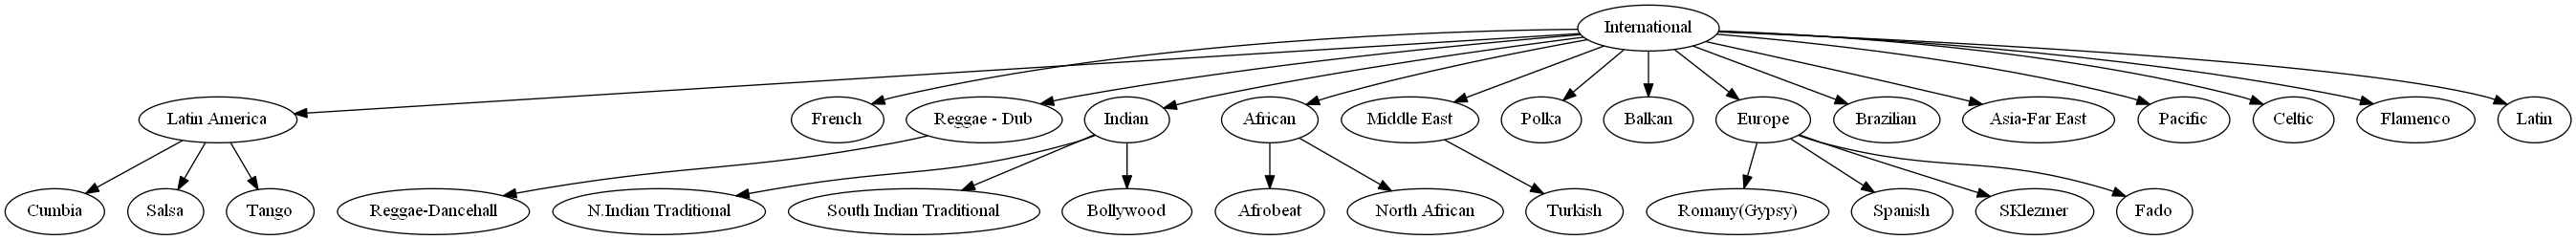

In [200]:
import os
os.environ['PATH'] = os.environ['PATH'] + ';' + os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

import pydot
import pydotplus
from sklearn import tree
from IPython.display import Image

International = pydotplus.graph_from_dot_file('International.dot') #<=====
Image(International.create_png()) #<====

In [28]:
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
from anytree.dotexport import RenderTreeGraph
from anytree import Node

Jazz = Node ('Jazz') #root
c_1 = Node ('Jazz Vocal', parent = Jazz)
c_2 = Node ('Free Jazz', parent = Jazz)
c_3 = Node ('Jazz - out', parent = Jazz)
c_4 = Node ('Be- Bop', parent = Jazz)
c_5 = Node ('Big Band /Swing', parent = Jazz)
c_6 = Node ('Modern Jazz', parent = Jazz)

DotExporter(Jazz).to_dotfile("Jazz.dot")

In [29]:
for line in DotExporter(Jazz):
    print(line)

digraph tree {
    "Jazz";
    "Jazz Vocal";
    "Free Jazz";
    "Jazz - out";
    "Be- Bop";
    "Big Band /Swing";
    "Modern Jazz";
    "Jazz" -> "Jazz Vocal";
    "Jazz" -> "Free Jazz";
    "Jazz" -> "Jazz - out";
    "Jazz" -> "Be- Bop";
    "Jazz" -> "Big Band /Swing";
    "Jazz" -> "Modern Jazz";
}


In [30]:
import os
os.environ['PATH'] = os.environ['PATH'] + ';' + os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

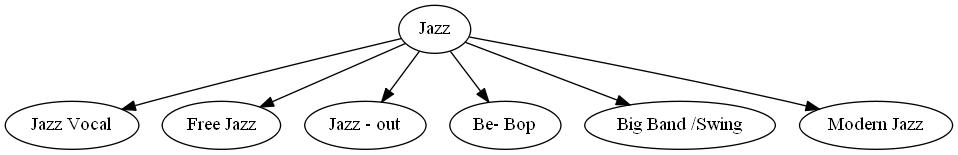

In [31]:
import pydot
import pydotplus
from sklearn import tree
from IPython.display import Image

Jazz = pydotplus.graph_from_dot_file('Jazz.dot') #<=====
Image(Jazz.create_png()) #<====

# Outliers

In [113]:
genres['#tracks'].max()

38154

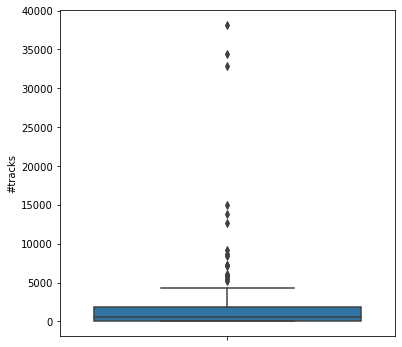

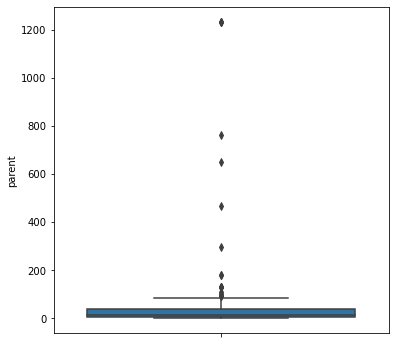

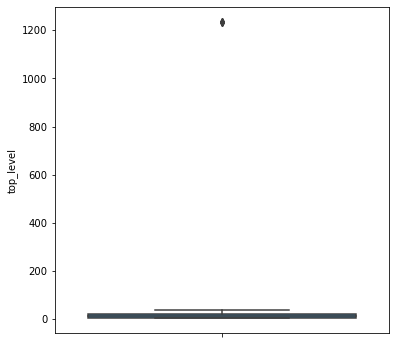

In [34]:
for i in numeric_col: 
    f = plt.figure(figsize=(6, 6))
    ax = sns.boxplot(x=genres[i],orient="v" )

In [116]:
genres['top_level'].values.tolist()

[38,
 2,
 3,
 4,
 5,
 38,
 20,
 8,
 9,
 10,
 14,
 12,
 13,
 14,
 15,
 38,
 17,
 1235,
 14,
 20,
 21,
 38,
 12,
 12,
 12,
 38,
 12,
 38,
 17,
 12,
 4,
 38,
 38,
 15,
 20,
 12,
 2,
 38,
 17,
 12,
 12,
 9,
 12,
 20,
 12,
 12,
 12,
 4,
 10,
 2,
 2,
 2,
 21,
 12,
 2,
 12,
 12,
 12,
 2,
 17,
 4,
 12,
 21,
 12,
 2,
 17,
 1235,
 12,
 12,
 12,
 2,
 2,
 38,
 2,
 9,
 20,
 20,
 12,
 9,
 13,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 4,
 17,
 15,
 15,
 15,
 15,
 15,
 38,
 5,
 20,
 20,
 2,
 38,
 2,
 15,
 15,
 38,
 38,
 1235,
 15,
 15,
 15,
 13,
 12,
 5,
 15,
 12,
 38,
 12,
 10,
 20,
 14,
 20,
 15,
 15,
 12,
 20,
 12,
 12,
 5,
 5,
 5,
 5,
 38,
 20,
 15,
 15,
 9,
 15,
 2,
 2,
 38,
 2,
 1235,
 21,
 21,
 3,
 21,
 2,
 2,
 9,
 5,
 21,
 15,
 2,
 38,
 2,
 13,
 21,
 4,
 2,
 2,
 2,
 38,
 1235]

# Visualizzazioni 

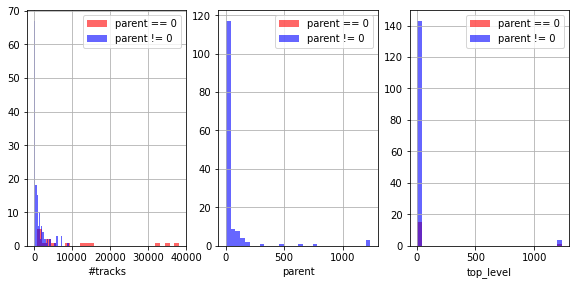

In [151]:
numeric_col = ['#tracks', 'parent', 'top_level']
plt.figure(figsize=(20, 20))

for i, column in enumerate(numeric_col, 1):
    plt.subplot(4, 6, i)
    genres[genres["parent"] == 0][column].hist(bins=30, color='red', label='parent == 0', alpha=0.6)
    genres[genres['parent'] != 0][column].hist(bins=30, color='blue', label='parent != 0', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

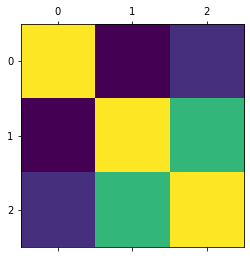

In [117]:
import matplotlib.pyplot as plt

plt.matshow(genres.corr())
plt.show()

In [125]:
from pandas_profiling import ProfileReport
prof = ProfileReport(genres, progress_bar = False)
print(prof)
prof.to_file(output_file='report.html')

# Prove ulteriori

In [132]:
tracks.columns

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          

In [137]:
tracks_begin = tracks['artist','active_year_begin'].to_frame()
tracks_end = tracks['artist','active_year_end'].to_frame()

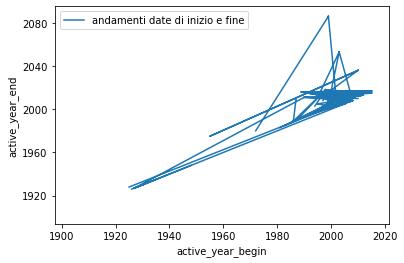

In [140]:
import matplotlib.pyplot as plt
plt.plot(tracks_begin, tracks_end, label='andamenti date di inizio e fine') 

plt.xlabel('active_year_begin')
plt.ylabel('active_year_end')
plt.legend()

In [142]:
ipd.display(tracks_begin, tracks_end)

,artist
,active_year_begin
track_id,
2,2006-01-01
3,2006-01-01
5,2006-01-01
10,NaT
20,1990-01-01
...,...
155316,NaT
155317,NaT


,artist
,active_year_end
track_id,
2,NaT
3,NaT
5,NaT
10,NaT
20,2011-01-01
...,...
155316,NaT
155317,NaT
